In [3]:
# 逆順のオーギュメンテーション

Credits to: https://www.kaggle.com/code/yasufuminakama/pppm-deberta-v3-large-baseline-w-w-b-train and https://www.kaggle.com/code/abhishek/creating-folds-properly-hopefully-p

I just applied Abhishek's great code to Nakama's great notebook to create folds grouped by anchors and stratified by score. Does this close the CV-LB gap? Let's see :-)

# About this notebook
- Deberta-v3-large starter code
- pip wheels is [here](https://www.kaggle.com/code/yasufuminakama/pppm-pip-wheels)
- Inference notebook is [here](https://www.kaggle.com/code/yasufuminakama/pppm-deberta-v3-large-baseline-inference)

If this notebook is helpful, feel free to upvote :)

In [4]:
# ====================================================
# CFG
# ====================================================
class CFG:
    
    # General
    exp='004'
    wandb=True
    resume=None  # [None, 'auto', 'always']
    save_checkpoint=True
    competition='PPPM'
    debug=False  # False
    seed=42

    # Dataset & DataLoader
    tokenizer_kwargs={
        'do_lower_case': True,
    }
    num_workers=4
    batch_size=16
    max_len=512

    # Model
    model="microsoft/deberta-v3-large"
    fc_dropout=0.2
    target_size=1

    # Optimizer & Scheduler
    scheduler='cosine' # ['linear', 'cosine']
    batch_scheduler=True
    num_cycles=0.5
    num_warmup_steps=0
    encoder_lr=2e-5
    decoder_lr=2e-5
    min_lr=1e-6
    eps=1e-6
    betas=(0.9, 0.999)
    weight_decay=0.01
    max_grad_norm=1000

    # Train
    n_fold=4
    trn_fold=[0, 1, 2, 3]
    epochs=4
    gradient_accumulation_steps=1
    print_freq=100
    apex=True
    train=True
    

if CFG.debug:
    CFG.epochs = 2
    CFG.trn_fold = [0]


# ====================================================
# Colab settings
# ====================================================
class ColabConfig:
    dataset_name = CFG.competition
    dataset_version = 'exp' + CFG.exp
    dataset_new = True  # 新しいデータセットか
    dataset_dir = None  # Kaggle Dataset にアップロードするディレクトリ
    dataset_note = ''  # 前の版からの変更点
    in_colab = False  # colab上にデータダウンロード

In [5]:
!nvcc --version
!python -c 'import torch; print(torch.__version__) '
!python --version
print('')
!nvidia-smi
print('')
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2020 NVIDIA Corporation
Built on Mon_Oct_12_20:09:46_PDT_2020
Cuda compilation tools, release 11.1, V11.1.105
Build cuda_11.1.TC455_06.29190527_0
1.11.0+cu113
Python 3.7.13

Fri Jun  3 00:30:55 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P0    28W / 250W |      0MiB / 16280MiB |      0%      Default |
|                

In [6]:
%%time
import sys
COLAB = "google.colab" in sys.modules

if COLAB:
    import os
    print('This environment is Google Colab')

    # mount drive
    from google.colab import drive
    if not os.path.isdir('/content/drive'):
        drive.mount('/content/drive')
    os.chdir('/content/drive/MyDrive/kaggle/PPPM/exps')

    # kaggle api token and update kaggle api
    from google.colab import files
    if not os.path.isfile('~/.kaggle/kaggle.json'):
        # files.upload()
        !mkdir -p ~/.kaggle
        !cp /content/drive/MyDrive/kaggle/kaggle.json ~/.kaggle/
        !chmod 600 ~/.kaggle/kaggle.json
        !pip install --upgrade --force-reinstall --no-deps -q kaggle

    if ColabConfig.in_colab:
        # make directory in colab
        !mkdir -p /content/input
        !mkdir -p /content/working

        # download dataset in colab
        import zipfile, glob
        os.chdir('/content/input')
        # !kaggle competitions download -qc birdclef-2022 -p birdclef-2022
        
        # !mkdir birdclef-2022
        # !cp /content/drive/MyDrive/kaggle/BirdCLEF2022/input/birdclef-2022/* ./birdclef-2022/

        for p in glob.glob('**/*.zip', recursive=True):
            print(p)
            d, f = os.path.split(p)
            # if f in ['']:
            #     continue
            with zipfile.ZipFile(p, 'r') as zipf:
                print('unzip: ', zipf)
                zipf.extractall(d)
                print('remove: ', f)
                os.remove(p)
        
        os.chdir('/content/working')

This environment is Google Colab
Mounted at /content/drive
     |████████████████████████████████| 58 kB 3.0 MB/s 
CPU times: user 1.33 s, sys: 310 ms, total: 1.64 s
Wall time: 25.5 s


In [7]:
# ====================================================
# Directory settings
# ====================================================
import os

INPUT_DIR = '../input/us-patent-phrase-to-phrase-matching/'
OUTPUT_DIR = f'/content/drive/MyDrive/kaggle/PPPM/output/{CFG.exp}/'
if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

# kaggle dataset config
ColabConfig.dataset_dir = OUTPUT_DIR

# WandB

In [8]:
# ====================================================
# wandb
# ====================================================
if CFG.wandb:
    
    !pip install -q wandb
    import wandb

    try:
        # from kaggle_secrets import UserSecretsClient
        # user_secrets = UserSecretsClient()
        # secret_value_0 = user_secrets.get_secret("wandb_api")
        with open('/content/drive/MyDrive/kaggle/wandb') as f:
           wandb_api_key = f.readline().rstrip('\n')
        wandb.login(key=wandb_api_key)
        anony = None
    except:
        anony = "must"
        print('If you want to use your W&B account, go to Add-ons -> Secrets and provide your W&B access token. Use the Label name as wandb_api. \nGet your W&B access token from here: https://wandb.ai/authorize')


    def class2dict(f):
        return dict((name, getattr(f, name)) for name in dir(f) if not name.startswith('__'))

    # https://docs.wandb.ai/ref/python/init
    run = wandb.init(project='PPPM', 
                     name=CFG.exp,
                     config=class2dict(CFG),
                    #  group=CFG.exp,
                     job_type="train",
                     resume=CFG.resume,  # 'auto'
                     anonymous=anony)

     |████████████████████████████████| 1.8 MB 7.4 MB/s 
     |████████████████████████████████| 181 kB 43.0 MB/s 
     |████████████████████████████████| 145 kB 31.1 MB/s 
     |████████████████████████████████| 63 kB 1.4 MB/s 


wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: y-haneji. Use `wandb login --relogin` to force relogin


# Library

In [9]:
# ====================================================
# Library
# ====================================================
import os
import gc
import re
import ast
import sys
import copy
import json
import time
import math
import shutil
import string
import pickle
import random
import joblib
import itertools
from pathlib import Path
import warnings
warnings.filterwarnings("ignore")

import scipy as sp
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
from tqdm.auto import tqdm
from sklearn.metrics import f1_score
from sklearn.model_selection import StratifiedKFold, GroupKFold, KFold

# # 20分ぐらい
# !pip uninstall -y torch torchvision
# !pip install 'https://download.pytorch.org/whl/cu111/torch-1.10.2%2Bcu111-cp37-cp37m-linux_x86_64.whl' 'https://download.pytorch.org/whl/cu111/torchvision-0.11.3%2Bcu111-cp37-cp37m-linux_x86_64.whl'
# !git clone https://github.com/NVIDIA/apex.git
# %cd apex
# !pip install --no-cache-dir --global-option="--cpp_ext" --global-option="--cuda_ext" .
# %cd ..
# # !rm -rf /content/drive/MyDrive/kaggle/PPPM/exps/apex/
# from apex import amp

import torch
print(f"torch.__version__: {torch.__version__}")
import torch.nn as nn
from torch.nn import Parameter
import torch.nn.functional as F
from torch.optim import Adam, SGD, AdamW
from torch.utils.data import DataLoader, Dataset

os.system('python -m pip install sentencepiece')
os.system('pip uninstall -y transformers')
os.system('pip uninstall -y tokenizers')
os.system('python -m pip install --no-index --find-links=../input/pppm-pip-wheels transformers')
os.system('python -m pip install --no-index --find-links=../input/pppm-pip-wheels tokenizers')
import tokenizers
import transformers
print(f"tokenizers.__version__: {tokenizers.__version__}")
print(f"transformers.__version__: {transformers.__version__}")
from transformers import AutoTokenizer, AutoModel, AutoConfig
from transformers import get_linear_schedule_with_warmup, get_cosine_schedule_with_warmup
%env TOKENIZERS_PARALLELISM=true

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

torch.__version__: 1.11.0+cu113
tokenizers.__version__: 0.12.1
transformers.__version__: 4.18.0
env: TOKENIZERS_PARALLELISM=true


# Utils

In [10]:
# ====================================================
# Utils
# ====================================================
def get_score(y_true, y_pred):
    score = sp.stats.pearsonr(y_true, y_pred)[0]
    return score


def get_logger(filename=OUTPUT_DIR+'train'):
    from logging import getLogger, INFO, StreamHandler, FileHandler, Formatter
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=f"{filename}.log")
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger

LOGGER = get_logger()

def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    
seed_everything(seed=42)

# Data Loading

In [11]:
# ====================================================
# Data Loading
# ====================================================
train = pd.read_csv(INPUT_DIR+'train.csv')
test = pd.read_csv(INPUT_DIR+'test.csv')
submission = pd.read_csv(INPUT_DIR+'sample_submission.csv')
print(f"train.shape: {train.shape}")
print(f"test.shape: {test.shape}")
print(f"submission.shape: {submission.shape}")
display(train.head())
display(test.head())
display(submission.head())

train.shape: (36473, 5)
test.shape: (36, 4)
submission.shape: (36, 2)


,id,anchor,target,context,score
0,37d61fd2272659b1,abatement,abatement of pollution,A47,0.50
1,7b9652b17b68b7a4,abatement,act of abating,A47,0.75
2,36d72442aefd8232,abatement,active catalyst,A47,0.25
3,5296b0c19e1ce60e,abatement,eliminating process,A47,0.50
4,54c1e3b9184cb5b6,abatement,forest region,A47,0.00


,id,anchor,target,context
0,4112d61851461f60,opc drum,inorganic photoconductor drum,G02
1,09e418c93a776564,adjust gas flow,altering gas flow,F23
2,36baf228038e314b,lower trunnion,lower locating,B60
3,1f37ead645e7f0c8,cap component,upper portion,D06
4,71a5b6ad068d531f,neural stimulation,artificial neural network,H04


,id,score
0,4112d61851461f60,0
1,09e418c93a776564,0
2,36baf228038e314b,0
3,1f37ead645e7f0c8,0
4,71a5b6ad068d531f,0


In [12]:
# ====================================================
# CPC Data
# ====================================================
def get_cpc_texts():
    contexts = []
    pattern = '[A-Z]\d+'
    for file_name in os.listdir('../input/cpc-data/CPCSchemeXML202105'):
        result = re.findall(pattern, file_name)
        if result:
            contexts.append(result)
    contexts = sorted(set(sum(contexts, [])))
    results = {}
    for cpc in ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'Y']:
        with open(f'../input/cpc-data/CPCTitleList202202/cpc-section-{cpc}_20220201.txt') as f:
            s = f.read()
        pattern = f'{cpc}\t\t.+'
        result = re.findall(pattern, s)
        cpc_result = result[0].lstrip(pattern)
        for context in [c for c in contexts if c[0] == cpc]:
            pattern = f'{context}\t\t.+'
            result = re.findall(pattern, s)
            results[context] = cpc_result + ". " + result[0].lstrip(pattern)
    return results


cpc_texts = get_cpc_texts()
torch.save(cpc_texts, OUTPUT_DIR+"cpc_texts.pth")
train['context_text'] = train['context'].map(cpc_texts)
test['context_text'] = test['context'].map(cpc_texts)
display(train.head())
display(test.head())

,id,anchor,target,context,score,context_text
0,37d61fd2272659b1,abatement,abatement of pollution,A47,0.50,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...
1,7b9652b17b68b7a4,abatement,act of abating,A47,0.75,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...
2,36d72442aefd8232,abatement,active catalyst,A47,0.25,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...
3,5296b0c19e1ce60e,abatement,eliminating process,A47,0.50,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...
4,54c1e3b9184cb5b6,abatement,forest region,A47,0.00,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...


,id,anchor,target,context,context_text
0,4112d61851461f60,opc drum,inorganic photoconductor drum,G02,PHYSICS. OPTICS
1,09e418c93a776564,adjust gas flow,altering gas flow,F23,MECHANICAL ENGINEERING; LIGHTING; HEATING; WEA...
2,36baf228038e314b,lower trunnion,lower locating,B60,PERFORMING OPERATIONS; TRANSPORTING. VEHICLES ...
3,1f37ead645e7f0c8,cap component,upper portion,D06,TEXTILES; PAPER. TREATMENT OF TEXTILES OR THE ...
4,71a5b6ad068d531f,neural stimulation,artificial neural network,H04,ELECTRICITY. ELECTRIC COMMUNICATION TECHNIQUE


In [13]:
# ';' を ',' に変換する
def preprocess_context(text: str):
    text = text.replace(';', '.')
    return text

train['context_text'] = train['context_text'].map(preprocess_context)
test['context_text'] = test['context_text'].map(preprocess_context)

In [14]:
# anchor, target, context_text をそれぞれ一文ずつとみなす
# anchorとtarget逆順にも並べる
train['text'] = train['anchor'] + '.' + ' [SEP] ' + train['target'] + '.' + ' [SEP] '  + train['context_text'] + '.'
test['text'] = test['anchor'] + '.' + ' [SEP] ' + test['target'] + '.' + ' [SEP] '  + test['context_text'] + '.'
train['text_rev'] = train['target'] + '.' + ' [SEP] ' + train['anchor'] + '.' + ' [SEP] '  + train['context_text'] + '.'
test['text_rev'] = test['target'] + '.' + ' [SEP] ' + test['anchor'] + '.' + ' [SEP] '  + test['context_text'] + '.'
display(train.head())
display(test.head())

,id,anchor,target,context,score,context_text,text,text_rev
0,37d61fd2272659b1,abatement,abatement of pollution,A47,0.50,HUMAN NECESSITIES. FURNITURE. DOMESTIC ARTICLE...,abatement. [SEP] abatement of pollution. [SEP]...,abatement of pollution. [SEP] abatement. [SEP]...
1,7b9652b17b68b7a4,abatement,act of abating,A47,0.75,HUMAN NECESSITIES. FURNITURE. DOMESTIC ARTICLE...,abatement. [SEP] act of abating. [SEP] HUMAN N...,act of abating. [SEP] abatement. [SEP] HUMAN N...
2,36d72442aefd8232,abatement,active catalyst,A47,0.25,HUMAN NECESSITIES. FURNITURE. DOMESTIC ARTICLE...,abatement. [SEP] active catalyst. [SEP] HUMAN ...,active catalyst. [SEP] abatement. [SEP] HUMAN ...
3,5296b0c19e1ce60e,abatement,eliminating process,A47,0.50,HUMAN NECESSITIES. FURNITURE. DOMESTIC ARTICLE...,abatement. [SEP] eliminating process. [SEP] HU...,eliminating process. [SEP] abatement. [SEP] HU...
4,54c1e3b9184cb5b6,abatement,forest region,A47,0.00,HUMAN NECESSITIES. FURNITURE. DOMESTIC ARTICLE...,abatement. [SEP] forest region. [SEP] HUMAN NE...,forest region. [SEP] abatement. [SEP] HUMAN NE...


,id,anchor,target,context,context_text,text,text_rev
0,4112d61851461f60,opc drum,inorganic photoconductor drum,G02,PHYSICS. OPTICS,opc drum. [SEP] inorganic photoconductor drum....,inorganic photoconductor drum. [SEP] opc drum....
1,09e418c93a776564,adjust gas flow,altering gas flow,F23,MECHANICAL ENGINEERING. LIGHTING. HEATING. WEA...,adjust gas flow. [SEP] altering gas flow. [SEP...,altering gas flow. [SEP] adjust gas flow. [SEP...
2,36baf228038e314b,lower trunnion,lower locating,B60,PERFORMING OPERATIONS. TRANSPORTING. VEHICLES ...,lower trunnion. [SEP] lower locating. [SEP] PE...,lower locating. [SEP] lower trunnion. [SEP] PE...
3,1f37ead645e7f0c8,cap component,upper portion,D06,TEXTILES. PAPER. TREATMENT OF TEXTILES OR THE ...,cap component. [SEP] upper portion. [SEP] TEXT...,upper portion. [SEP] cap component. [SEP] TEXT...
4,71a5b6ad068d531f,neural stimulation,artificial neural network,H04,ELECTRICITY. ELECTRIC COMMUNICATION TECHNIQUE,neural stimulation. [SEP] artificial neural ne...,artificial neural network. [SEP] neural stimul...


# EDA

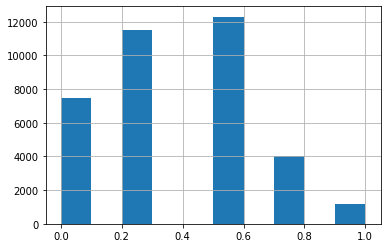

In [15]:
train['score'].hist()

In [16]:
display(train['context'].apply(lambda x: x[0]).value_counts())

B    8019
H    6195
G    6013
C    5288
A    4094
F    4054
E    1531
D    1279
Name: context, dtype: int64

- Y is not in training data, but may be in test data?

# CV split

In [17]:
#credits to: https://www.kaggle.com/code/abhishek/creating-folds-properly-hopefully-p

!pip install -q iterative-stratification
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold

dfx = pd.get_dummies(train, columns=["score"]).groupby(["anchor"], as_index=False).sum()
cols = [c for c in dfx.columns if c.startswith("score_") or c == "anchor"]
dfx = dfx[cols]

mskf = MultilabelStratifiedKFold(n_splits=CFG.n_fold, shuffle=True, random_state=42)
labels = [c for c in dfx.columns if c != "anchor"]
dfx_labels = dfx[labels]
dfx["fold"] = -1

for fold, (trn_, val_) in enumerate(mskf.split(dfx, dfx_labels)):
    print(len(trn_), len(val_))
    dfx.loc[val_, "fold"] = fold

train = train.merge(dfx[["anchor", "fold"]], on="anchor", how="left")
print(train.fold.value_counts())

550 183
549 184
550 183
550 183
3    9622
0    9379
1    8860
2    8612
Name: fold, dtype: int64


In [18]:
if CFG.debug:
    display(train.groupby('fold').size())
    train = train.sample(n=1000, random_state=0).reset_index(drop=True)
    display(train.groupby('fold').size())

# tokenizer

In [19]:
# ====================================================
# tokenizer
# ====================================================
tokenizer = AutoTokenizer.from_pretrained(CFG.model, **CFG.tokenizer_kwargs)
tokenizer.save_pretrained(OUTPUT_DIR+'tokenizer/')
CFG.tokenizer = tokenizer

Downloading:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/580 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.35M [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


# Dataset

In [20]:
# ====================================================
# Define max_len
# ====================================================
lengths_dict = {}

lengths = []
tk0 = tqdm(cpc_texts.values(), total=len(cpc_texts))
for text in tk0:
    length = len(tokenizer(text, add_special_tokens=False)['input_ids'])
    lengths.append(length)
lengths_dict['context_text'] = lengths

for text_col in ['anchor', 'target']:
    lengths = []
    tk0 = tqdm(train[text_col].fillna("").values, total=len(train))
    for text in tk0:
        length = len(tokenizer(text, add_special_tokens=False)['input_ids'])
        lengths.append(length)
    lengths_dict[text_col] = lengths
    
CFG.max_len = max(lengths_dict['anchor']) + max(lengths_dict['target'])\
                + max(lengths_dict['context_text']) + 4 # CLS + SEP + SEP + SEP
LOGGER.info(f"max_len: {CFG.max_len}")

  0%|          | 0/136 [00:00<?, ?it/s]

  0%|          | 0/36473 [00:00<?, ?it/s]

  0%|          | 0/36473 [00:00<?, ?it/s]

max_len: 106


In [25]:
# ====================================================
# Dataset
# ====================================================
def prepare_input(cfg, text):
    inputs = cfg.tokenizer(text,
                           add_special_tokens=True,
                           max_length=cfg.max_len,
                           padding="max_length",
                           return_offsets_mapping=False)
    for k, v in inputs.items():
        inputs[k] = torch.tensor(v, dtype=torch.long)
    return inputs


class TrainDataset(Dataset):
    def __init__(self, cfg, df, phase: str ='train'):
        self.cfg = cfg
        self.texts = df['text'].values
        self.texts_rev = df['text_rev'].values
        self.labels = df['score'].values

        # 学習はオーギュメンテーション
        rev_mask = (np.random.rand(len(df))) > 0.5  # 0~1の一様分布が閾値より大きいならmask
        texts_aug = np.where(rev_mask, self.texts_rev, self.texts)
        if phase=='train':
            self.texts = texts_aug

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, item):
        inputs = prepare_input(self.cfg, self.texts[item])
        label = torch.tensor(self.labels[item], dtype=torch.float)
        return inputs, label

In [28]:
train_dataset = TrainDataset(CFG, train, 'train')
inputs, label = train_dataset[0]
print(inputs)
print(label)

{'input_ids': tensor([    1, 47284,   265,  6435,   260,     2, 47284,   260,     2,   857,
        19629,   260,  2075,   260,  3090,  2502,   289,  6328,   260,  1818,
        13498,   260, 10224, 13498,   260, 22157, 13952,   267,  1042,   260,
            2,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0]), 'token_type_ids': tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

# Model

In [29]:
# ====================================================
# Model
# ====================================================
class CustomModel(nn.Module):
    def __init__(self, cfg, config_path=None, pretrained=False):
        super().__init__()
        self.cfg = cfg
        if config_path is None:
            self.config = AutoConfig.from_pretrained(cfg.model, output_hidden_states=True)
        else:
            self.config = torch.load(config_path)
        if pretrained:
            self.model = AutoModel.from_pretrained(cfg.model, config=self.config)
        else:
            self.model = AutoModel.from_config(self.config)
        self.fc_dropout = nn.Dropout(cfg.fc_dropout)
        self.fc = nn.Linear(self.config.hidden_size, self.cfg.target_size)
        self._init_weights(self.fc)
        self.attention = nn.Sequential(
            nn.Linear(self.config.hidden_size, 512),
            nn.Tanh(),
            nn.Linear(512, 1),
            nn.Softmax(dim=1)
        )
        self._init_weights(self.attention)
        
    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            module.weight.data.normal_(mean=0.0, std=self.config.initializer_range)
            if module.bias is not None:
                module.bias.data.zero_()
        elif isinstance(module, nn.Embedding):
            module.weight.data.normal_(mean=0.0, std=self.config.initializer_range)
            if module.padding_idx is not None:
                module.weight.data[module.padding_idx].zero_()
        elif isinstance(module, nn.LayerNorm):
            module.bias.data.zero_()
            module.weight.data.fill_(1.0)
        
    def feature(self, inputs):
        outputs = self.model(**inputs)
        last_hidden_states = outputs[0]
        # feature = torch.mean(last_hidden_states, 1)
        weights = self.attention(last_hidden_states)
        feature = torch.sum(weights * last_hidden_states, dim=1)
        return feature

    def forward(self, inputs):
        feature = self.feature(inputs)
        output = self.fc(self.fc_dropout(feature))
        return output

# Helpler functions

In [30]:
# ====================================================
# Helper functions
# ====================================================
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (remain %s)' % (asMinutes(s), asMinutes(rs))


def train_fn(fold, train_loader, model, criterion, optimizer, epoch, scheduler, device):
    model.train()
    scaler = torch.cuda.amp.GradScaler(enabled=CFG.apex)
    losses = AverageMeter()
    start = end = time.time()
    global_step = 0
    for step, (inputs, labels) in enumerate(train_loader):
        for k, v in inputs.items():
            inputs[k] = v.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)
        with torch.cuda.amp.autocast(enabled=CFG.apex):
            y_preds = model(inputs)
        loss = criterion(y_preds.view(-1, 1), labels.view(-1, 1))
        if CFG.gradient_accumulation_steps > 1:
            loss = loss / CFG.gradient_accumulation_steps
        losses.update(loss.item(), batch_size)
        scaler.scale(loss).backward()
        grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), CFG.max_grad_norm)
        if (step + 1) % CFG.gradient_accumulation_steps == 0:
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()
            global_step += 1
            if CFG.batch_scheduler:
                scheduler.step()
        end = time.time()
        if step % CFG.print_freq == 0 or step == (len(train_loader)-1):
            print('Epoch: [{0}][{1}/{2}] '
                  'Elapsed {remain:s} '
                  'Loss: {loss.val:.4f}({loss.avg:.4f}) '
                  'Grad: {grad_norm:.4f}  '
                  'LR: {lr:.8f}  '
                  .format(epoch+1, step, len(train_loader), 
                          remain=timeSince(start, float(step+1)/len(train_loader)),
                          loss=losses,
                          grad_norm=grad_norm,
                          lr=scheduler.get_lr()[0]))
        if CFG.wandb:
            wandb.log({f"[fold{fold}] loss": losses.val,
                       f"[fold{fold}] lr": scheduler.get_lr()[0]})
    return losses.avg


def valid_fn(valid_loader, model, criterion, device):
    losses = AverageMeter()
    model.eval()
    preds = []
    start = end = time.time()
    for step, (inputs, labels) in enumerate(valid_loader):
        for k, v in inputs.items():
            inputs[k] = v.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)
        with torch.no_grad():
            y_preds = model(inputs)
        loss = criterion(y_preds.view(-1, 1), labels.view(-1, 1))
        if CFG.gradient_accumulation_steps > 1:
            loss = loss / CFG.gradient_accumulation_steps
        losses.update(loss.item(), batch_size)
        preds.append(y_preds.sigmoid().to('cpu').numpy())
        end = time.time()
        if step % CFG.print_freq == 0 or step == (len(valid_loader)-1):
            print('EVAL: [{0}/{1}] '
                  'Elapsed {remain:s} '
                  'Loss: {loss.val:.4f}({loss.avg:.4f}) '
                  .format(step, len(valid_loader),
                          loss=losses,
                          remain=timeSince(start, float(step+1)/len(valid_loader))))
    predictions = np.concatenate(preds)
    predictions = np.concatenate(predictions)
    return losses.avg, predictions


def inference_fn(test_loader, model, device):
    preds = []
    model.eval()
    model.to(device)
    tk0 = tqdm(test_loader, total=len(test_loader))
    for inputs in tk0:
        for k, v in inputs.items():
            inputs[k] = v.to(device)
        with torch.no_grad():
            y_preds = model(inputs)
        preds.append(y_preds.sigmoid().to('cpu').numpy())
    predictions = np.concatenate(preds)
    return predictions

In [31]:
# ====================================================
# train loop
# ====================================================
def train_loop(folds, fold, checkpoint_path=None,):
    
    LOGGER.info(f"========== fold: {fold} training ==========")

    # ====================================================
    # loader
    # ====================================================
    train_folds = folds[folds['fold'] != fold].reset_index(drop=True)
    valid_folds = folds[folds['fold'] == fold].reset_index(drop=True)
    valid_labels = valid_folds['score'].values
    
    train_dataset = TrainDataset(CFG, train_folds, phase='train')
    valid_dataset = TrainDataset(CFG, valid_folds, phase='val')

    train_loader = DataLoader(train_dataset,
                              batch_size=CFG.batch_size,
                              shuffle=True,
                              num_workers=CFG.num_workers, pin_memory=True, drop_last=True)
    valid_loader = DataLoader(valid_dataset,
                              batch_size=CFG.batch_size,
                              shuffle=False,
                              num_workers=CFG.num_workers, pin_memory=True, drop_last=False)

    # ====================================================
    # model & optimizer
    # ====================================================
    model = CustomModel(CFG, config_path=None, pretrained=True)
    torch.save(model.config, OUTPUT_DIR+'config.pth')
    model.to(device)
    
    def get_optimizer_params(model, encoder_lr, decoder_lr, weight_decay=0.0):
        param_optimizer = list(model.named_parameters())
        no_decay = ["bias", "LayerNorm.bias", "LayerNorm.weight"]
        optimizer_parameters = [
            {'params': [p for n, p in model.model.named_parameters() if not any(nd in n for nd in no_decay)],
             'lr': encoder_lr, 'weight_decay': weight_decay},
            {'params': [p for n, p in model.model.named_parameters() if any(nd in n for nd in no_decay)],
             'lr': encoder_lr, 'weight_decay': 0.0},
            {'params': [p for n, p in model.named_parameters() if "model" not in n],
             'lr': decoder_lr, 'weight_decay': 0.0}
        ]
        return optimizer_parameters

    optimizer_parameters = get_optimizer_params(model,
                                                encoder_lr=CFG.encoder_lr, 
                                                decoder_lr=CFG.decoder_lr,
                                                weight_decay=CFG.weight_decay)
    optimizer = AdamW(optimizer_parameters, lr=CFG.encoder_lr, eps=CFG.eps, betas=CFG.betas)
    
    # ====================================================
    # scheduler
    # ====================================================
    def get_scheduler(cfg, optimizer, num_train_steps):
        if cfg.scheduler == 'linear':
            scheduler = get_linear_schedule_with_warmup(
                optimizer, num_warmup_steps=cfg.num_warmup_steps, num_training_steps=num_train_steps
            )
        elif cfg.scheduler == 'cosine':
            scheduler = get_cosine_schedule_with_warmup(
                optimizer, num_warmup_steps=cfg.num_warmup_steps, num_training_steps=num_train_steps, num_cycles=cfg.num_cycles
            )
        return scheduler
    
    num_train_steps = int(len(train_folds) / CFG.batch_size * CFG.epochs)
    scheduler = get_scheduler(CFG, optimizer, num_train_steps)

    # ====================================================
    # loop
    # ====================================================
    criterion = nn.BCEWithLogitsLoss(reduction="mean")
    
    best_score = 0.
    epoch = 0

    if wandb.run.resumed:
        checkpoint = torch.load(checkpoint_path)  # wandb.restore(checkpoint_path)
        model.load_state_dict(checkpoint['model'])
        optimizer.load_state_dict(checkpoint['model'])
        scheduler.load_state_dict(checkpoint['scheduler'])
        # amp.load_state_dict(checkpoint['amp'])
        epoch = checkpoint['epoeh'] + 1  # 保存時のエポックが読み出されるので+1
        best_score = checkpoint['best_score']

    while epoch < CFG.epochs:
        start_time = time.time()

        # train
        avg_loss = train_fn(fold, train_loader, model, criterion, optimizer, epoch, scheduler, device)

        # eval
        avg_val_loss, predictions = valid_fn(valid_loader, model, criterion, device)
        
        # scoring
        score = get_score(valid_labels, predictions)

        elapsed = time.time() - start_time

        LOGGER.info(f'Epoch {epoch+1} - avg_train_loss: {avg_loss:.4f}  avg_val_loss: {avg_val_loss:.4f}  time: {elapsed:.0f}s')
        LOGGER.info(f'Epoch {epoch+1} - Score: {score:.4f}')
        if CFG.wandb:
            wandb.log({f"[fold{fold}] epoch": epoch+1, 
                       f"[fold{fold}] avg_train_loss": avg_loss, 
                       f"[fold{fold}] avg_val_loss": avg_val_loss,
                       f"[fold{fold}] score": score})
        
        if CFG.save_checkpoint:
            torch.save({'model': model.state_dict(),
                        'optimizer': optimizer.state_dict(),
                        'scheduler': scheduler.state_dict(),
                        # 'amp': amp.state_dict(),
                        'epoch': epoch,
                        'best_score': best_score},
                        checkpoint_path)
            # wandb.save(checkpoint_path)  # driveでos.symlinkでエラーが出る

        if best_score < score:
            best_score = score
            LOGGER.info(f'Epoch {epoch+1} - Save Best Score: {best_score:.4f} Model')
            torch.save({'model': model.state_dict(),
                        'predictions': predictions},
                        OUTPUT_DIR+f"{CFG.model.replace('/', '-')}_fold{fold}_best.pth")
            
        epoch += 1

    predictions = torch.load(OUTPUT_DIR+f"{CFG.model.replace('/', '-')}_fold{fold}_best.pth", 
                             map_location=torch.device('cpu'))['predictions']
    valid_folds['pred'] = predictions

    torch.cuda.empty_cache()
    gc.collect()
    
    return valid_folds

In [32]:
if __name__ == '__main__':
    
    def get_result(oof_df):
        labels = oof_df['score'].values
        preds = oof_df['pred'].values
        score = get_score(labels, preds)
        LOGGER.info(f'Score: {score:<.4f}')
    
    if CFG.train:
        oof_df = pd.DataFrame()
        fold = 0

        if wandb.run.resumed:
            checkpoint = torch.load(OUTPUT_DIR + 'fold_checkpoint.pth')
            fold = checkpoint['fold'] + 1  # 保存時のfoldが読み出されるので+1
            oof_df = checkpoint['oof_df']

        while fold < CFG.n_fold:
            if fold in CFG.trn_fold:
                _oof_df = train_loop(train, fold, checkpoint_path=OUTPUT_DIR + 'epoch_checkpoint.pth')
                oof_df = pd.concat([oof_df, _oof_df])
                LOGGER.info(f"========== fold: {fold} result ==========")
                get_result(_oof_df)
            if CFG.save_checkpoint:
                torch.save({'fold': fold,
                            'oof_df': oof_df},
                            OUTPUT_DIR + 'fold_checkpoint.pth')
            fold += 1

        oof_df = oof_df.reset_index(drop=True)
        LOGGER.info(f"========== CV ==========")
        get_result(oof_df)
        oof_df.to_pickle(OUTPUT_DIR+'oof_df.pkl')
        
    if CFG.wandb & (~CFG.debug):
        wandb.finish()

    os.remove(OUTPUT_DIR + 'fold_checkpoint.pth')
    os.remove(OUTPUT_DIR + 'epoch_checkpoint.pth')

========== fold: 0 training ==========


Downloading:   0%|          | 0.00/833M [00:00<?, ?B/s]

Some weights of the model checkpoint at microsoft/deberta-v3-large were not used when initializing DebertaV2Model: ['lm_predictions.lm_head.bias', 'mask_predictions.dense.weight', 'mask_predictions.LayerNorm.bias', 'mask_predictions.classifier.bias', 'lm_predictions.lm_head.LayerNorm.weight', 'mask_predictions.classifier.weight', 'lm_predictions.lm_head.dense.bias', 'lm_predictions.lm_head.dense.weight', 'mask_predictions.LayerNorm.weight', 'mask_predictions.dense.bias', 'lm_predictions.lm_head.LayerNorm.bias']
- This IS expected if you are initializing DebertaV2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaV2Model from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch: [1][0/1693] Elapsed 0m 1s (remain 31m 32s) Loss: 0.6780(0.6780) Grad: inf  LR: 0.00002000  
Epoch: [1][100/1693] Elapsed 1m 20s (remain 21m 3s) Loss: 0.5382(0.6301) Grad: 70308.0625  LR: 0.00001999  
Epoch: [1][200/1693] Elapsed 2m 39s (remain 19m 43s) Loss: 0.6036(0.6166) Grad: 28629.9160  LR: 0.00001996  
Epoch: [1][300/1693] Elapsed 3m 58s (remain 18m 22s) Loss: 0.5775(0.6066) Grad: 28699.1016  LR: 0.00001990  
Epoch: [1][400/1693] Elapsed 5m 17s (remain 17m 2s) Loss: 0.6460(0.5993) Grad: 29881.5059  LR: 0.00001983  
Epoch: [1][500/1693] Elapsed 6m 36s (remain 15m 42s) Loss: 0.3759(0.5900) Grad: 21752.9004  LR: 0.00001973  
Epoch: [1][600/1693] Elapsed 7m 55s (remain 14m 23s) Loss: 0.6059(0.5827) Grad: 36414.5312  LR: 0.00001961  
Epoch: [1][700/1693] Elapsed 9m 14s (remain 13m 4s) Loss: 0.5534(0.5795) Grad: 20094.0234  LR: 0.00001948  
Epoch: [1][800/1693] Elapsed 10m 33s (remain 11m 45s) Loss: 0.5799(0.5774) Grad: 17836.5840  LR: 0.00001932  
Epoch: [1][900/1693] Elapsed 11

Epoch 1 - avg_train_loss: 0.5613  avg_val_loss: 0.5534  time: 1458s
Epoch 1 - Score: 0.8072


EVAL: [586/587] Elapsed 2m 0s (remain 0m 0s) Loss: 0.6890(0.5534) 


Epoch 1 - Save Best Score: 0.8072 Model


Epoch: [2][0/1693] Elapsed 0m 1s (remain 37m 0s) Loss: 0.5440(0.5440) Grad: 68147.2656  LR: 0.00001707  
Epoch: [2][100/1693] Elapsed 1m 28s (remain 23m 8s) Loss: 0.5913(0.5227) Grad: 45336.7578  LR: 0.00001673  
Epoch: [2][200/1693] Elapsed 2m 47s (remain 20m 42s) Loss: 0.4279(0.5205) Grad: 54718.8945  LR: 0.00001638  
Epoch: [2][300/1693] Elapsed 4m 6s (remain 18m 59s) Loss: 0.5562(0.5178) Grad: 197884.8906  LR: 0.00001602  
Epoch: [2][400/1693] Elapsed 5m 25s (remain 17m 28s) Loss: 0.5203(0.5175) Grad: 73529.9922  LR: 0.00001564  
Epoch: [2][500/1693] Elapsed 6m 44s (remain 16m 2s) Loss: 0.5553(0.5165) Grad: 51123.0625  LR: 0.00001525  
Epoch: [2][600/1693] Elapsed 8m 3s (remain 14m 38s) Loss: 0.4754(0.5170) Grad: 51937.6719  LR: 0.00001485  
Epoch: [2][700/1693] Elapsed 9m 22s (remain 13m 16s) Loss: 0.6325(0.5163) Grad: 126933.7031  LR: 0.00001444  
Epoch: [2][800/1693] Elapsed 10m 41s (remain 11m 54s) Loss: 0.6360(0.5179) Grad: 37759.1680  LR: 0.00001402  
Epoch: [2][900/1693] Ela

Epoch 2 - avg_train_loss: 0.5178  avg_val_loss: 0.5669  time: 1468s
Epoch 2 - Score: 0.8130


EVAL: [586/587] Elapsed 2m 0s (remain 0m 0s) Loss: 0.6868(0.5669) 


Epoch 2 - Save Best Score: 0.8130 Model


Epoch: [3][0/1693] Elapsed 0m 1s (remain 41m 24s) Loss: 0.5516(0.5516) Grad: 28884.7715  LR: 0.00001000  
Epoch: [3][100/1693] Elapsed 1m 25s (remain 22m 31s) Loss: 0.4101(0.5006) Grad: 248185.8906  LR: 0.00000953  
Epoch: [3][200/1693] Elapsed 2m 45s (remain 20m 28s) Loss: 0.5379(0.5019) Grad: 85909.5000  LR: 0.00000907  
Epoch: [3][300/1693] Elapsed 4m 4s (remain 18m 51s) Loss: 0.5306(0.5018) Grad: 50750.3125  LR: 0.00000861  
Epoch: [3][400/1693] Elapsed 5m 23s (remain 17m 22s) Loss: 0.5037(0.5026) Grad: 20272.6465  LR: 0.00000815  
Epoch: [3][500/1693] Elapsed 6m 42s (remain 15m 57s) Loss: 0.5280(0.5021) Grad: 115889.7891  LR: 0.00000770  
Epoch: [3][600/1693] Elapsed 8m 1s (remain 14m 34s) Loss: 0.4990(0.5034) Grad: 41827.1719  LR: 0.00000725  
Epoch: [3][700/1693] Elapsed 9m 20s (remain 13m 12s) Loss: 0.4698(0.5036) Grad: 92971.7031  LR: 0.00000681  
Epoch: [3][800/1693] Elapsed 10m 39s (remain 11m 51s) Loss: 0.4814(0.5059) Grad: 88484.7891  LR: 0.00000637  
Epoch: [3][900/1693] 

Epoch 3 - avg_train_loss: 0.5056  avg_val_loss: 0.5884  time: 1464s
Epoch 3 - Score: 0.8110


EVAL: [586/587] Elapsed 2m 0s (remain 0m 0s) Loss: 0.6821(0.5884) 
Epoch: [4][0/1693] Elapsed 0m 1s (remain 32m 30s) Loss: 0.3946(0.3946) Grad: 11470.4678  LR: 0.00000293  
Epoch: [4][100/1693] Elapsed 1m 23s (remain 21m 52s) Loss: 0.4378(0.5068) Grad: 222184.9219  LR: 0.00000261  
Epoch: [4][200/1693] Elapsed 2m 42s (remain 20m 7s) Loss: 0.5081(0.5014) Grad: 62478.8125  LR: 0.00000230  
Epoch: [4][300/1693] Elapsed 4m 1s (remain 18m 37s) Loss: 0.5445(0.5001) Grad: 35449.6641  LR: 0.00000202  
Epoch: [4][400/1693] Elapsed 5m 20s (remain 17m 13s) Loss: 0.5179(0.4980) Grad: 44213.1328  LR: 0.00000175  
Epoch: [4][500/1693] Elapsed 6m 39s (remain 15m 51s) Loss: 0.5976(0.4989) Grad: 63804.3281  LR: 0.00000149  
Epoch: [4][600/1693] Elapsed 7m 58s (remain 14m 30s) Loss: 0.6395(0.4990) Grad: 38734.2773  LR: 0.00000126  
Epoch: [4][700/1693] Elapsed 9m 17s (remain 13m 9s) Loss: 0.4483(0.4977) Grad: 89707.8438  LR: 0.00000104  
Epoch: [4][800/1693] Elapsed 10m 36s (remain 11m 48s) Loss: 0.3911

Epoch 4 - avg_train_loss: 0.4980  avg_val_loss: 0.6068  time: 1462s
Epoch 4 - Score: 0.8061


EVAL: [586/587] Elapsed 2m 0s (remain 0m 0s) Loss: 0.6847(0.6068) 


========== fold: 0 result ==========
Score: 0.8130
========== fold: 1 training ==========
Some weights of the model checkpoint at microsoft/deberta-v3-large were not used when initializing DebertaV2Model: ['lm_predictions.lm_head.bias', 'mask_predictions.dense.weight', 'mask_predictions.LayerNorm.bias', 'mask_predictions.classifier.bias', 'lm_predictions.lm_head.LayerNorm.weight', 'mask_predictions.classifier.weight', 'lm_predictions.lm_head.dense.bias', 'lm_predictions.lm_head.dense.weight', 'mask_predictions.LayerNorm.weight', 'mask_predictions.dense.bias', 'lm_predictions.lm_head.LayerNorm.bias']
- This IS expected if you are initializing DebertaV2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaV2Model from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequ

Epoch: [1][0/1725] Elapsed 0m 1s (remain 42m 14s) Loss: 0.7816(0.7816) Grad: inf  LR: 0.00002000  
Epoch: [1][100/1725] Elapsed 1m 23s (remain 22m 23s) Loss: 0.6350(0.6298) Grad: 51517.6602  LR: 0.00001999  
Epoch: [1][200/1725] Elapsed 2m 42s (remain 20m 33s) Loss: 0.5729(0.6089) Grad: 27518.3184  LR: 0.00001996  
Epoch: [1][300/1725] Elapsed 4m 1s (remain 19m 2s) Loss: 0.6132(0.5980) Grad: 16818.2520  LR: 0.00001991  
Epoch: [1][400/1725] Elapsed 5m 20s (remain 17m 37s) Loss: 0.6049(0.5892) Grad: 106873.5312  LR: 0.00001983  
Epoch: [1][500/1725] Elapsed 6m 39s (remain 16m 15s) Loss: 0.5054(0.5834) Grad: 26842.1426  LR: 0.00001974  
Epoch: [1][600/1725] Elapsed 7m 58s (remain 14m 54s) Loss: 0.5519(0.5800) Grad: 22447.5293  LR: 0.00001963  
Epoch: [1][700/1725] Elapsed 9m 17s (remain 13m 33s) Loss: 0.5133(0.5776) Grad: 13471.6660  LR: 0.00001950  
Epoch: [1][800/1725] Elapsed 10m 36s (remain 12m 13s) Loss: 0.5455(0.5742) Grad: 45666.5039  LR: 0.00001934  
Epoch: [1][900/1725] Elapsed 

Epoch 1 - avg_train_loss: 0.5594  avg_val_loss: 0.5686  time: 1480s
Epoch 1 - Score: 0.7826


EVAL: [553/554] Elapsed 1m 53s (remain 0m 0s) Loss: 0.5159(0.5686) 


Epoch 1 - Save Best Score: 0.7826 Model


Epoch: [2][0/1725] Elapsed 0m 1s (remain 43m 34s) Loss: 0.5077(0.5077) Grad: 133395.1562  LR: 0.00001707  
Epoch: [2][100/1725] Elapsed 1m 27s (remain 23m 21s) Loss: 0.5881(0.5331) Grad: 45536.7461  LR: 0.00001674  
Epoch: [2][200/1725] Elapsed 2m 46s (remain 21m 1s) Loss: 0.4698(0.5268) Grad: 213372.7812  LR: 0.00001640  
Epoch: [2][300/1725] Elapsed 4m 5s (remain 19m 20s) Loss: 0.5145(0.5256) Grad: 72414.7734  LR: 0.00001604  
Epoch: [2][400/1725] Elapsed 5m 24s (remain 17m 50s) Loss: 0.4888(0.5221) Grad: 47623.3320  LR: 0.00001567  
Epoch: [2][500/1725] Elapsed 6m 43s (remain 16m 25s) Loss: 0.5647(0.5200) Grad: 152794.9219  LR: 0.00001529  
Epoch: [2][600/1725] Elapsed 8m 2s (remain 15m 1s) Loss: 0.3760(0.5190) Grad: 176269.8125  LR: 0.00001490  
Epoch: [2][700/1725] Elapsed 9m 21s (remain 13m 40s) Loss: 0.5725(0.5168) Grad: 45281.1133  LR: 0.00001450  
Epoch: [2][800/1725] Elapsed 10m 40s (remain 12m 18s) Loss: 0.6428(0.5167) Grad: 273633.0938  LR: 0.00001409  
Epoch: [2][900/1725]

Epoch 2 - avg_train_loss: 0.5164  avg_val_loss: 0.5842  time: 1484s
Epoch 2 - Score: 0.7975


EVAL: [553/554] Elapsed 1m 54s (remain 0m 0s) Loss: 0.5064(0.5842) 


Epoch 2 - Save Best Score: 0.7975 Model


Epoch: [3][0/1725] Elapsed 0m 1s (remain 39m 57s) Loss: 0.4994(0.4994) Grad: 108265.0781  LR: 0.00001000  
Epoch: [3][100/1725] Elapsed 1m 23s (remain 22m 16s) Loss: 0.4219(0.5055) Grad: 55354.7461  LR: 0.00000955  
Epoch: [3][200/1725] Elapsed 2m 44s (remain 20m 48s) Loss: 0.4900(0.5091) Grad: 61147.6562  LR: 0.00000909  
Epoch: [3][300/1725] Elapsed 4m 3s (remain 19m 12s) Loss: 0.4768(0.5104) Grad: 51676.5039  LR: 0.00000864  
Epoch: [3][400/1725] Elapsed 5m 22s (remain 17m 44s) Loss: 0.4705(0.5122) Grad: 144642.6094  LR: 0.00000819  
Epoch: [3][500/1725] Elapsed 6m 41s (remain 16m 21s) Loss: 0.5877(0.5095) Grad: 200326.9688  LR: 0.00000775  
Epoch: [3][600/1725] Elapsed 8m 0s (remain 14m 58s) Loss: 0.5130(0.5080) Grad: 87735.2109  LR: 0.00000731  
Epoch: [3][700/1725] Elapsed 9m 19s (remain 13m 37s) Loss: 0.5483(0.5089) Grad: 101756.7656  LR: 0.00000687  
Epoch: [3][800/1725] Elapsed 10m 38s (remain 12m 16s) Loss: 0.5260(0.5073) Grad: 389896.9375  LR: 0.00000644  
Epoch: [3][900/172

Epoch 3 - avg_train_loss: 0.5047  avg_val_loss: 0.5844  time: 1482s
Epoch 3 - Score: 0.8009


EVAL: [553/554] Elapsed 1m 53s (remain 0m 0s) Loss: 0.5048(0.5844) 


Epoch 3 - Save Best Score: 0.8009 Model


Epoch: [4][0/1725] Elapsed 0m 1s (remain 44m 47s) Loss: 0.4541(0.4541) Grad: 32279.1621  LR: 0.00000293  
Epoch: [4][100/1725] Elapsed 1m 24s (remain 22m 33s) Loss: 0.6087(0.5011) Grad: 89347.6250  LR: 0.00000262  
Epoch: [4][200/1725] Elapsed 2m 45s (remain 20m 55s) Loss: 0.2981(0.5019) Grad: 65734.1797  LR: 0.00000232  
Epoch: [4][300/1725] Elapsed 4m 4s (remain 19m 16s) Loss: 0.5794(0.5032) Grad: 61359.6836  LR: 0.00000204  
Epoch: [4][400/1725] Elapsed 5m 23s (remain 17m 47s) Loss: 0.4180(0.5022) Grad: 42027.4609  LR: 0.00000177  
Epoch: [4][500/1725] Elapsed 6m 42s (remain 16m 23s) Loss: 0.4954(0.5032) Grad: 68588.6719  LR: 0.00000152  
Epoch: [4][600/1725] Elapsed 8m 1s (remain 15m 0s) Loss: 0.4877(0.5028) Grad: 38359.9258  LR: 0.00000129  
Epoch: [4][700/1725] Elapsed 9m 20s (remain 13m 38s) Loss: 0.4408(0.5018) Grad: 51476.8516  LR: 0.00000107  
Epoch: [4][800/1725] Elapsed 10m 39s (remain 12m 17s) Loss: 0.5503(0.5021) Grad: 237411.7344  LR: 0.00000088  
Epoch: [4][900/1725] El

Epoch 4 - avg_train_loss: 0.4983  avg_val_loss: 0.5956  time: 1484s
Epoch 4 - Score: 0.7991


EVAL: [553/554] Elapsed 1m 53s (remain 0m 0s) Loss: 0.5068(0.5956) 


========== fold: 1 result ==========
Score: 0.8009
========== fold: 2 training ==========
Some weights of the model checkpoint at microsoft/deberta-v3-large were not used when initializing DebertaV2Model: ['lm_predictions.lm_head.bias', 'mask_predictions.dense.weight', 'mask_predictions.LayerNorm.bias', 'mask_predictions.classifier.bias', 'lm_predictions.lm_head.LayerNorm.weight', 'mask_predictions.classifier.weight', 'lm_predictions.lm_head.dense.bias', 'lm_predictions.lm_head.dense.weight', 'mask_predictions.LayerNorm.weight', 'mask_predictions.dense.bias', 'lm_predictions.lm_head.LayerNorm.bias']
- This IS expected if you are initializing DebertaV2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaV2Model from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequ

Epoch: [1][0/1741] Elapsed 0m 1s (remain 44m 30s) Loss: 0.7160(0.7160) Grad: 104051.8594  LR: 0.00002000  
Epoch: [1][100/1741] Elapsed 1m 23s (remain 22m 37s) Loss: 0.7311(0.6425) Grad: 77291.3281  LR: 0.00001999  
Epoch: [1][200/1741] Elapsed 2m 42s (remain 20m 45s) Loss: 0.5806(0.6101) Grad: 60225.0859  LR: 0.00001996  
Epoch: [1][300/1741] Elapsed 4m 1s (remain 19m 16s) Loss: 0.5674(0.5966) Grad: 70812.4375  LR: 0.00001991  
Epoch: [1][400/1741] Elapsed 5m 20s (remain 17m 51s) Loss: 0.6689(0.5922) Grad: 48585.9414  LR: 0.00001984  
Epoch: [1][500/1741] Elapsed 6m 39s (remain 16m 28s) Loss: 0.5925(0.5934) Grad: 21777.9746  LR: 0.00001975  
Epoch: [1][600/1741] Elapsed 7m 58s (remain 15m 7s) Loss: 0.6184(0.5884) Grad: 31015.1641  LR: 0.00001963  
Epoch: [1][700/1741] Elapsed 9m 17s (remain 13m 47s) Loss: 0.5797(0.5834) Grad: 32184.6875  LR: 0.00001950  
Epoch: [1][800/1741] Elapsed 10m 36s (remain 12m 26s) Loss: 0.4805(0.5798) Grad: 18673.0488  LR: 0.00001935  
Epoch: [1][900/1741] E

Epoch 1 - avg_train_loss: 0.5640  avg_val_loss: 0.5478  time: 1490s
Epoch 1 - Score: 0.8184


EVAL: [538/539] Elapsed 1m 50s (remain 0m 0s) Loss: 0.3836(0.5478) 


Epoch 1 - Save Best Score: 0.8184 Model


Epoch: [2][0/1741] Elapsed 0m 1s (remain 43m 34s) Loss: 0.3804(0.3804) Grad: 69999.3906  LR: 0.00001707  
Epoch: [2][100/1741] Elapsed 1m 26s (remain 23m 30s) Loss: 0.5499(0.5241) Grad: 153131.1875  LR: 0.00001674  
Epoch: [2][200/1741] Elapsed 2m 46s (remain 21m 12s) Loss: 0.5328(0.5169) Grad: 80740.6641  LR: 0.00001640  
Epoch: [2][300/1741] Elapsed 4m 4s (remain 19m 31s) Loss: 0.4871(0.5172) Grad: 77391.2344  LR: 0.00001605  
Epoch: [2][400/1741] Elapsed 5m 24s (remain 18m 2s) Loss: 0.3649(0.5150) Grad: 118115.2578  LR: 0.00001568  
Epoch: [2][500/1741] Elapsed 6m 43s (remain 16m 37s) Loss: 0.4838(0.5164) Grad: 46519.4805  LR: 0.00001531  
Epoch: [2][600/1741] Elapsed 8m 1s (remain 15m 14s) Loss: 0.6082(0.5150) Grad: 50488.6992  LR: 0.00001492  
Epoch: [2][700/1741] Elapsed 9m 21s (remain 13m 52s) Loss: 0.5027(0.5158) Grad: 49724.3516  LR: 0.00001452  
Epoch: [2][800/1741] Elapsed 10m 40s (remain 12m 31s) Loss: 0.5339(0.5165) Grad: 21866.0410  LR: 0.00001412  
Epoch: [2][900/1741] E

Epoch 2 - avg_train_loss: 0.5204  avg_val_loss: 0.5497  time: 1495s
Epoch 2 - Score: 0.8266


EVAL: [538/539] Elapsed 1m 51s (remain 0m 0s) Loss: 0.3803(0.5497) 


Epoch 2 - Save Best Score: 0.8266 Model


Epoch: [3][0/1741] Elapsed 0m 1s (remain 45m 19s) Loss: 0.6021(0.6021) Grad: 252562.2656  LR: 0.00001000  
Epoch: [3][100/1741] Elapsed 1m 25s (remain 23m 3s) Loss: 0.4977(0.5026) Grad: 33875.4922  LR: 0.00000955  
Epoch: [3][200/1741] Elapsed 2m 45s (remain 21m 9s) Loss: 0.5177(0.5060) Grad: 35238.4492  LR: 0.00000910  
Epoch: [3][300/1741] Elapsed 4m 4s (remain 19m 31s) Loss: 0.5120(0.5009) Grad: 117565.3281  LR: 0.00000865  
Epoch: [3][400/1741] Elapsed 5m 23s (remain 18m 1s) Loss: 0.5189(0.5013) Grad: 71921.0625  LR: 0.00000820  
Epoch: [3][500/1741] Elapsed 6m 42s (remain 16m 36s) Loss: 0.4650(0.5022) Grad: 31810.0039  LR: 0.00000776  
Epoch: [3][600/1741] Elapsed 8m 1s (remain 15m 13s) Loss: 0.5776(0.5032) Grad: 65000.4609  LR: 0.00000732  
Epoch: [3][700/1741] Elapsed 9m 20s (remain 13m 51s) Loss: 0.6665(0.5031) Grad: 256097.2344  LR: 0.00000689  
Epoch: [3][800/1741] Elapsed 10m 39s (remain 12m 30s) Loss: 0.6130(0.5049) Grad: 44108.9062  LR: 0.00000647  
Epoch: [3][900/1741] El

Epoch 3 - avg_train_loss: 0.5083  avg_val_loss: 0.5668  time: 1493s
Epoch 3 - Score: 0.8215


EVAL: [538/539] Elapsed 1m 50s (remain 0m 0s) Loss: 0.3614(0.5668) 
Epoch: [4][0/1741] Elapsed 0m 1s (remain 34m 1s) Loss: 0.4420(0.4420) Grad: 81103.2578  LR: 0.00000293  
Epoch: [4][100/1741] Elapsed 1m 24s (remain 22m 49s) Loss: 0.5177(0.4966) Grad: 42171.9727  LR: 0.00000262  
Epoch: [4][200/1741] Elapsed 2m 43s (remain 20m 52s) Loss: 0.6003(0.4994) Grad: 272093.6875  LR: 0.00000232  
Epoch: [4][300/1741] Elapsed 4m 2s (remain 19m 19s) Loss: 0.5290(0.4986) Grad: 48465.9922  LR: 0.00000204  
Epoch: [4][400/1741] Elapsed 5m 21s (remain 17m 53s) Loss: 0.5711(0.4995) Grad: 30483.1719  LR: 0.00000177  
Epoch: [4][500/1741] Elapsed 6m 40s (remain 16m 30s) Loss: 0.4716(0.4992) Grad: 53397.6680  LR: 0.00000153  
Epoch: [4][600/1741] Elapsed 7m 59s (remain 15m 9s) Loss: 0.4625(0.4989) Grad: 104552.7109  LR: 0.00000130  
Epoch: [4][700/1741] Elapsed 9m 18s (remain 13m 48s) Loss: 0.4522(0.4998) Grad: 19744.2852  LR: 0.00000108  
Epoch: [4][800/1741] Elapsed 10m 37s (remain 12m 27s) Loss: 0.58

Epoch 4 - avg_train_loss: 0.5016  avg_val_loss: 0.5739  time: 1491s
Epoch 4 - Score: 0.8205


EVAL: [538/539] Elapsed 1m 50s (remain 0m 0s) Loss: 0.3541(0.5739) 


========== fold: 2 result ==========
Score: 0.8266
========== fold: 3 training ==========
Some weights of the model checkpoint at microsoft/deberta-v3-large were not used when initializing DebertaV2Model: ['lm_predictions.lm_head.bias', 'mask_predictions.dense.weight', 'mask_predictions.LayerNorm.bias', 'mask_predictions.classifier.bias', 'lm_predictions.lm_head.LayerNorm.weight', 'mask_predictions.classifier.weight', 'lm_predictions.lm_head.dense.bias', 'lm_predictions.lm_head.dense.weight', 'mask_predictions.LayerNorm.weight', 'mask_predictions.dense.bias', 'lm_predictions.lm_head.LayerNorm.bias']
- This IS expected if you are initializing DebertaV2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaV2Model from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequ

Epoch: [1][0/1678] Elapsed 0m 1s (remain 39m 51s) Loss: 0.8128(0.8128) Grad: inf  LR: 0.00002000  
Epoch: [1][100/1678] Elapsed 1m 24s (remain 21m 52s) Loss: 0.5210(0.6323) Grad: 27935.6836  LR: 0.00001999  
Epoch: [1][200/1678] Elapsed 2m 43s (remain 19m 59s) Loss: 0.6250(0.6117) Grad: 63097.8711  LR: 0.00001996  
Epoch: [1][300/1678] Elapsed 4m 2s (remain 18m 27s) Loss: 0.6221(0.5939) Grad: 50522.9492  LR: 0.00001990  
Epoch: [1][400/1678] Elapsed 5m 21s (remain 17m 2s) Loss: 0.5200(0.5874) Grad: 21005.3691  LR: 0.00001982  
Epoch: [1][500/1678] Elapsed 6m 40s (remain 15m 40s) Loss: 0.5478(0.5829) Grad: 19195.9141  LR: 0.00001973  
Epoch: [1][600/1678] Elapsed 7m 59s (remain 14m 18s) Loss: 0.5941(0.5787) Grad: 31474.9844  LR: 0.00001961  
Epoch: [1][700/1678] Elapsed 9m 18s (remain 12m 57s) Loss: 0.6135(0.5741) Grad: 23621.7734  LR: 0.00001947  
Epoch: [1][800/1678] Elapsed 10m 37s (remain 11m 37s) Loss: 0.4413(0.5702) Grad: 18666.7129  LR: 0.00001931  
Epoch: [1][900/1678] Elapsed 1

Epoch 1 - avg_train_loss: 0.5589  avg_val_loss: 0.5609  time: 1455s
Epoch 1 - Score: 0.7807
Epoch 1 - Save Best Score: 0.7807 Model


Epoch: [2][0/1678] Elapsed 0m 1s (remain 41m 33s) Loss: 0.4766(0.4766) Grad: 23056.7402  LR: 0.00001707  
Epoch: [2][100/1678] Elapsed 1m 26s (remain 22m 27s) Loss: 0.5675(0.5237) Grad: 220205.2344  LR: 0.00001673  
Epoch: [2][200/1678] Elapsed 2m 45s (remain 20m 17s) Loss: 0.5708(0.5190) Grad: 144470.2969  LR: 0.00001638  
Epoch: [2][300/1678] Elapsed 4m 4s (remain 18m 38s) Loss: 0.5478(0.5165) Grad: 95581.3359  LR: 0.00001601  
Epoch: [2][400/1678] Elapsed 5m 23s (remain 17m 9s) Loss: 0.6246(0.5149) Grad: 330804.7812  LR: 0.00001563  
Epoch: [2][500/1678] Elapsed 6m 42s (remain 15m 45s) Loss: 0.5349(0.5174) Grad: 46061.2188  LR: 0.00001523  
Epoch: [2][600/1678] Elapsed 8m 1s (remain 14m 22s) Loss: 0.5627(0.5172) Grad: 32723.4707  LR: 0.00001483  
Epoch: [2][700/1678] Elapsed 9m 20s (remain 13m 1s) Loss: 0.6142(0.5182) Grad: 99017.9219  LR: 0.00001442  
Epoch: [2][800/1678] Elapsed 10m 39s (remain 11m 40s) Loss: 0.4878(0.5183) Grad: 89615.5469  LR: 0.00001399  
Epoch: [2][900/1678] E

Epoch 2 - avg_train_loss: 0.5180  avg_val_loss: 0.5708  time: 1455s
Epoch 2 - Score: 0.7934
Epoch 2 - Save Best Score: 0.7934 Model


Epoch: [3][0/1678] Elapsed 0m 1s (remain 35m 43s) Loss: 0.5208(0.5208) Grad: 53033.8828  LR: 0.00001000  
Epoch: [3][100/1678] Elapsed 1m 27s (remain 22m 45s) Loss: 0.5451(0.5087) Grad: 41744.3359  LR: 0.00000953  
Epoch: [3][200/1678] Elapsed 2m 47s (remain 20m 28s) Loss: 0.4417(0.5059) Grad: 130391.8516  LR: 0.00000906  
Epoch: [3][300/1678] Elapsed 4m 6s (remain 18m 47s) Loss: 0.5455(0.5056) Grad: 37410.0586  LR: 0.00000860  
Epoch: [3][400/1678] Elapsed 5m 25s (remain 17m 16s) Loss: 0.4893(0.5048) Grad: 26228.1895  LR: 0.00000813  
Epoch: [3][500/1678] Elapsed 6m 44s (remain 15m 50s) Loss: 0.4466(0.5051) Grad: 107742.1484  LR: 0.00000768  
Epoch: [3][600/1678] Elapsed 8m 3s (remain 14m 26s) Loss: 0.4425(0.5046) Grad: 85764.4219  LR: 0.00000722  
Epoch: [3][700/1678] Elapsed 9m 22s (remain 13m 4s) Loss: 0.4524(0.5052) Grad: 141142.5625  LR: 0.00000678  
Epoch: [3][800/1678] Elapsed 10m 41s (remain 11m 42s) Loss: 0.5952(0.5044) Grad: 138473.0469  LR: 0.00000634  
Epoch: [3][900/1678]

Epoch 3 - avg_train_loss: 0.5053  avg_val_loss: 0.5943  time: 1458s
Epoch 3 - Score: 0.7886


Epoch: [4][0/1678] Elapsed 0m 1s (remain 32m 57s) Loss: 0.5610(0.5610) Grad: 62147.3867  LR: 0.00000293  
Epoch: [4][100/1678] Elapsed 1m 23s (remain 21m 43s) Loss: 0.4283(0.5056) Grad: 51946.8047  LR: 0.00000260  
Epoch: [4][200/1678] Elapsed 2m 42s (remain 19m 54s) Loss: 0.5988(0.5036) Grad: 88961.1953  LR: 0.00000230  
Epoch: [4][300/1678] Elapsed 4m 1s (remain 18m 24s) Loss: 0.4966(0.5002) Grad: 39202.0703  LR: 0.00000201  
Epoch: [4][400/1678] Elapsed 5m 20s (remain 17m 0s) Loss: 0.4323(0.4995) Grad: 44081.1133  LR: 0.00000173  
Epoch: [4][500/1678] Elapsed 6m 39s (remain 15m 38s) Loss: 0.6093(0.4961) Grad: 47291.2266  LR: 0.00000148  
Epoch: [4][600/1678] Elapsed 7m 58s (remain 14m 17s) Loss: 0.5210(0.4965) Grad: 45858.3242  LR: 0.00000124  
Epoch: [4][700/1678] Elapsed 9m 17s (remain 12m 56s) Loss: 0.4247(0.4952) Grad: 98397.7500  LR: 0.00000103  
Epoch: [4][800/1678] Elapsed 10m 36s (remain 11m 36s) Loss: 0.5317(0.4954) Grad: 41311.7773  LR: 0.00000083  
Epoch: [4][900/1678] El

Epoch 4 - avg_train_loss: 0.4984  avg_val_loss: 0.5976  time: 1453s
Epoch 4 - Score: 0.7880
========== fold: 3 result ==========
Score: 0.7934
========== CV ==========
Score: 0.8074


[fold0] avg_train_loss,█▃▂▁
[fold0] avg_val_loss,▁▃▆█
[fold0] epoch,▁▃▆█
[fold0] loss,▇▆▅▆▆▅▇▆▄▅▄▅▅▄▆▃▄▅▄▇▁▇▄▄▄▄▃█▃▂▅▆▂▅▅▃▁▂▆▃
[fold0] lr,███████▇▇▇▇▇▆▆▆▆▆▅▅▅▄▄▄▄▃▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁
[fold0] score,▂█▆▁
[fold1] avg_train_loss,█▃▂▁
[fold1] avg_val_loss,▁▅▅█
[fold1] epoch,▁▃▆█
[fold1] loss,▇▄█▅▆▃▅█▃▁▄▄▅▄▆▂▁▃▆▅▅▄▄▆▃▄▄▄▅▄▄▄▄▂▅▄▄▃▅▂
[fold1] lr,███████▇▇▇▇▇▇▆▆▆▅▅▅▅▄▄▄▄▃▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁


In [33]:
import os
import json
from kaggle.api.kaggle_api_extended import KaggleApi

ID = 'hanejiyuto'
DATASET_ID = ColabConfig.dataset_name + '-' + ColabConfig.dataset_version
UPLOAD_DIR = ColabConfig.dataset_dir
VERSION_NOTES = ColabConfig.dataset_note

def dataset_create_new():
    dataset_metadata = {}
    dataset_metadata['id'] = f'{ID}/{DATASET_ID}'
    dataset_metadata['licenses'] = [{'name': 'CC0-1.0'}]
    dataset_metadata['title'] = DATASET_ID
    with open(os.path.join(UPLOAD_DIR, 'dataset-metadata.json'), 'w') as f:
        json.dump(dataset_metadata, f, indent=4)
    api = KaggleApi()
    api.authenticate()
    # api.dataset_create_new(folder=UPLOAD_DIR, convert_to_csv=False, dir_mode='tar')
    !kaggle datasets create -t -p $UPLOAD_DIR -r tar

def dataset_create_version():  # バージョンアップデート
    dataset_metadata = {}
    dataset_metadata['id'] = f'{ID}/{DATASET_ID}'
    dataset_metadata['licenses'] = [{'name': 'CC0-1.0'}]
    dataset_metadata['title'] = DATASET_ID
    if not os.path.exists('dataset-metadata.json'):
        with open(os.path.join(UPLOAD_DIR, 'dataset-metadata.json'), 'w') as f:
            json.dump(dataset_metadata, f, indent=4)
    api = KaggleApi()
    api.authenticate()
    # api.dataset_create_version(folder=UPLOAD_DIR, version_notes=VERSION_NOTES, convert_to_csv=False, dir_mode='tar')
    !kaggle datasets version -t -p $UPLOAD_DIR -r tar -m $VERSION_NOTES

if CFG.debug:
    pass
elif ColabConfig.dataset_new:
    dataset_create_new()
else:
    dataset_create_version()

Starting upload for file train.log
100% 2.19k/2.19k [00:02<00:00, 842B/s]
Upload successful: train.log (2KB)
Starting upload for file cpc_texts.pth
100% 13.9k/13.9k [00:02<00:00, 5.57kB/s]
Upload successful: cpc_texts.pth (14KB)
Starting upload for file tokenizer.tar
100% 2.36M/2.36M [00:03<00:00, 716kB/s]
Upload successful: tokenizer.tar (2MB)
Starting upload for file config.pth
100% 2.48k/2.48k [00:02<00:00, 916B/s]
Upload successful: config.pth (2KB)
Starting upload for file microsoft-deberta-v3-large_fold0_best.pth
100% 1.62G/1.62G [00:37<00:00, 46.4MB/s]
Upload successful: microsoft-deberta-v3-large_fold0_best.pth (2GB)
Starting upload for file microsoft-deberta-v3-large_fold1_best.pth
100% 1.62G/1.62G [00:36<00:00, 47.2MB/s]
Upload successful: microsoft-deberta-v3-large_fold1_best.pth (2GB)
Starting upload for file microsoft-deberta-v3-large_fold2_best.pth
100% 1.62G/1.62G [00:39<00:00, 43.5MB/s]
Upload successful: microsoft-deberta-v3-large_fold2_best.pth (2GB)
Starting upload f